In [2]:
# magic to reload modules when they change
%load_ext autoreload
%autoreload 2

# Dynamic Analysis of a bridge structure

## Geometry of the bridge

In [3]:
import os
import time
import shutil
import logging
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy import Matrix, lambdify
from utils.truss_geometric import *
from utils.truss_constraints import *
from utils.truss_helpers import *
from utils.simple_beam_helper import calculate_simple_essential_elements, calculate_simple_element_node
from sympy.utilities.codegen import codegen
import cython

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [4]:
span = 25
angle = 45
beam_length = 2.5
skip_rod = []

# Note simple and simple_cant are no longer bridges since we don't have lower and upper beams
truss_mode = "warren" # warren, pratt, howe, simple, simple_cant 
diag, height, spacing = None, None, None

if "simple" not in truss_mode:
    # Calculation of bridge geometry
    height, spacing, diag = calculate_bridge(span, angle, beam_length, truss_mode)
    n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_essential_elements(
        span, spacing, truss_mode, skip_rod)

    # Recalculates the skip_rod to match the truss design
    skip_rod = truss_design(n_bot_beams, n_rods, truss_mode)
    n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_essential_elements(
        span, spacing, truss_mode, skip_rod)
    
    # Calculation of nodal coordinates and construction of par, pel matrices and element node indices
    # Building priorty: Beams -> Columns -> Rods
    nodal_coord, par, pel, ele_nod, n_par_tot = calculate_element_node(span, spacing, height, n_dim, 
                                                                    n_par_nod, truss_mode, skip_rod)
else:
    # You can specify beam_partition or provide custom spacings or column placements
    beam_partition = 1  # Number of divisions in the beam
    cantilever_sides = 2 # Beams on the edge of the bridge
    # Optionally, specify custom column placements
    # col_placements = [0, 5, 10, 15, 20, 25]
    # Optionally, specify custom spacings
    # spacing = [5, 5, 5, 5, 5] # Set to None when using beam_partition

    # Calculate essential elements
    n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_simple_essential_elements(
        span, spacing, truss_mode, beam_partition=beam_partition, cantilever_sides=cantilever_sides)
    spacing = span / n_beams
    
    # Calculate nodal coordinates and element relations
    nodal_coord, par, pel, ele_nod, n_par_tot = calculate_simple_element_node(
        span, spacing, n_dim, n_par_nod, truss_mode, beam_partition=beam_partition)

print(f"There are {n_columns} columns, {n_beams} beams, {n_nod_tot} nodes, {n_ele_tot} elements.")



# Seperating nodal coordinates into x and y coordinates
X = np.zeros(n_nod_tot, dtype=float)
Y = np.zeros(n_nod_tot, dtype=float)
X[:] = nodal_coord[:, 0]
Y[:] = nodal_coord[:, 1]


# -------- BOUNDARY CONDITIONS --------
# Focuses only on the first and last node connect to the ground (roller, pin, fixed)
if "simple" not in truss_mode:
    W = boundary_conditions(n_bot_beams, n_par_nod, n_nod_tot, supports=["pin", "roller"])
else:
    W = boundary_conditions_simple(n_nod_tot, supports=["pin", "roller"])

pel = pel.astype(np.int32)
W = W.astype(np.int32)
ele_nod = ele_nod.astype(np.int32)


# # -------- ELEMENT CHARACTERIZING DATA --------
h = np.zeros(n_ele_tot, dtype=np.float32)
J = np.zeros(n_ele_tot, dtype=np.float32)
A = np.zeros(n_ele_tot, dtype=np.float32)
beta = np.zeros(n_ele_tot,dtype=np.float32)
ro = np.zeros(n_ele_tot,dtype=np.float32)
E = np.zeros(n_ele_tot, dtype=np.float32)


# # -------- ELEMENT PROPERTIES --------
J, A, h, beta, ro, E, G = calculate_element_properties(n_ele_tot, n_columns, n_beams, diag, spacing, height, J, A, h, beta, ro, E, X, Y, ele_nod, shear_mod,
                                                 width_properties, height_properties, unit_weight_properties, elastic_mod_properties, truss_mode)
beam_indices = np.arange(n_ele_tot - n_rods, dtype=np.int32)
rod_indices = np.arange(n_ele_tot - n_rods, n_ele_tot, dtype=np.int32)

There are 0 columns, 19 beams, 21 nodes, 39 elements.


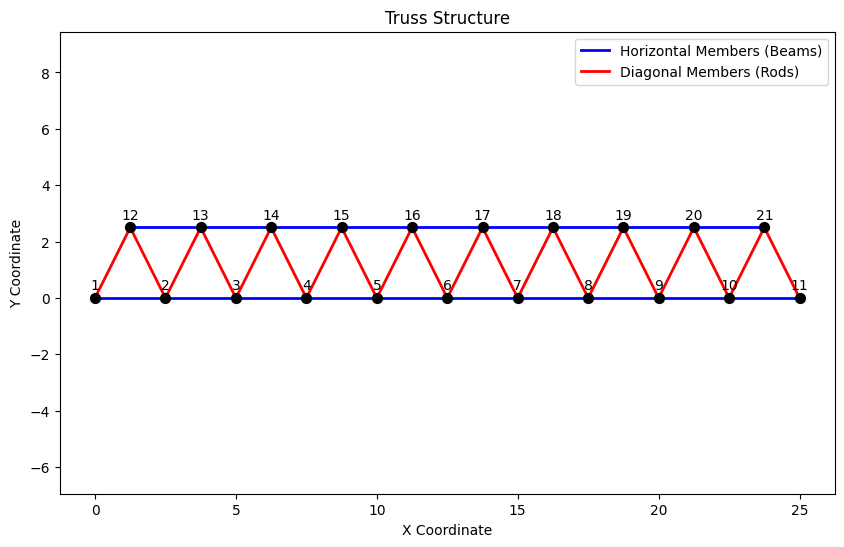

In [6]:
# Define element colors based on type
horizontal_color = 'blue'
vertical_color = 'green'
diagonal_color = 'red'

# Define legend labels
horizontal_label = "Horizontal Members (Beams)"
vertical_label = "Vertical Members (Columns)"
diagonal_label = "Diagonal Members (Rods)"

# Create figure
plt.figure(figsize=(10, 6))

# Plot elements with different colors
for i, (n1, n2) in enumerate(ele_nod):
    x1, y1 = X[n1], Y[n1]
    x2, y2 = X[n2], Y[n2]

    # Determine type of member
    if y1 == y2:  # Horizontal
        plt.plot([x1, x2], [y1, y2], horizontal_color, linewidth=2, label=horizontal_label if i == 0 else "")
    elif x1 == x2:  # Vertical
        plt.plot([x1, x2], [y1, y2], vertical_color, linewidth=2, label=vertical_label if i == 18 else "")
    else:  # Diagonal
        plt.plot([x1, x2], [y1, y2], diagonal_color, linewidth=2, label=diagonal_label if i == 28 else "")

# Plot nodes
plt.scatter(X, Y, color='black', s=50, zorder=3)

# Annotate node numbers
for i, (x, y) in enumerate(zip(X, Y)):
    plt.text(x, y + 0.3, str(i+1), fontsize=10, ha='center', color='black')

# Set axis
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Truss Structure')
plt.axis('equal')

# Add legend
plt.legend(loc='upper right')

# Show plot
plt.show()

## Bridge displacements and matrix construction

In [5]:
beam_type = "bernoulli"
use_lagrangian = False

(x, xi, h_e, beta_e, beta_curr, qe, a_arr, b_arr,
    c_arr, d_arr, e_arr, A_e, E_e, J_e, ro_e, T, fo_E, X_old, Y_old,
        Qglo_pel_curr, w_arr, r_arr, f_arr, g_arr) = initialize_symbols(n_par_ele)

v1, u1, v2, u2 = compute_v_u(qe, beta_e)


(ve_beam_func, ue_beam_func, ve_beam, ue_beam, ve_rod_func, 
    ue_rod_func, ve_rod, ue_rod, alpha_e_beam) = calculate_displacement_equations(x, xi, h_e, beta_e, qe, a_arr, b_arr, c_arr, d_arr, e_arr,
                                     beam_type, use_lagrangian)

pot_beam, kin_beam, pot_rod, kin_rod = calculate_energies(beam_type, ve_beam, ue_beam, alpha_e_beam, ve_rod,
                                                          ue_rod, x, h_e, E_e, J_e, A_e, ro_e, G, k_shear)

(K_beam, M_beam, K_rod, M_rod, K_beam_func, M_beam_func, 
 K_rod_func, M_rod_func) = construct_lambdified_matrices(n_par_ele, pot_beam, kin_beam, pot_rod, kin_rod, 
                                                         qe, h_e, A_e, E_e, J_e, beta_e, ro_e)



(X_new_beam, Y_new_beam, X_new_rod, Y_new_rod, X_new_beam_func, Y_new_beam_func, 
 X_new_rod_func, Y_new_rod_func) = calculate_global_displacements(Qglo_pel_curr, beta_e, h_e, x, xi, f_arr, 
                                                                         g_arr, w_arr, r_arr, beam_type,
                                                                         X_old, Y_old, use_lagrangian)


In [6]:
%%capture
#Turn the symbolic functions into lambdified functions suitable for Cython
functions = [
    ("K_beam_func", K_beam),
    ("M_beam_func", M_beam),
    ("K_rod_func", K_rod),
    ("M_rod_func", M_rod),
]

# Generate C code
codegen(
    functions,
    language="C",
    project="utils/cython",
    to_files=True
)


functions = [
    ("X_beam_func", X_new_beam),
    ("Y_beam_func", Y_new_beam),
    ("X_rod_func", X_new_rod),
    ("Y_rod_func", Y_new_rod),
]

# Generate C code
codegen(
    functions,
    language="C",
    project="utils/cython",
    to_files=True
)


def replace_include_guards(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Replace slashes with underscores in the include guards
    content = content.replace('UTILS/CYTHON__', 'UTILS_CYTHON__')
    
    # Add whitespace after the define directive if missing
    content = content.replace('#defineUTILS_CYTHON__', '#define UTILS_CYTHON__')
    
    with open(file_path, 'w') as file:
        file.write(content)

# Paths to the header files
header_files = [
    "K_beam_func.h",
    "X_beam_func.h"
]

# Move the generated C files and modify the include guards in the header files
for header_file in header_files:
    source_path = header_file
    dest_path = os.path.join("utils/cython", header_file)
    
    # Replace include guards
    replace_include_guards(source_path)
    
    # Move the header file to the destination
    shutil.move(source_path, dest_path)

# Move the generated C files
shutil.move("K_beam_func.c", "utils/cython/K_beam_func.c")
shutil.move("X_beam_func.c", "utils/cython/X_beam_func.c")

!cd utils/cython && python setup.py build_ext --inplace

from utils.cython.assemble_matrices import assemble_global_matrices_cython, apply_boundary_conditions_cython, compute_element_matrices_cython, compute_element_coordinates_cython

In [ ]:
# Construct stiffness using Cython
start_time = time.time()
for i in range(2000):
    element_matrices = compute_element_matrices_cython(
        n_ele_tot, beam_indices, rod_indices,
        h, A, E, J, beta, ro
    )
    K, M = assemble_global_matrices_cython(element_matrices, pel, n_par_tot)
    K, M = apply_boundary_conditions_cython(K, M, W, tol=1e-5)
print(f"Time taken: {time.time() - start_time}")

# # Same commands as above, but using the Python implementation
# K, M = assemble_global_matrices(n_par_ele, n_par_tot, n_ele_tot, K_beam_func, M_beam_func, K_rod_func, M_rod_func,
#                                 h, A, E, J, beta, ro, pel, n_rods)
# K, M = apply_boundary_conditions(K, M, W, tol=1e-5)

Time taken: 0.45444273948669434


In [63]:
print_matrix(M)
print_matrix(K)

                 1        2        3        4        5        6        7        8        9       10       11       12       13       14       15       16       17       18       19       20       21       22       23       24       25       26       27       28       29       30       31       32       33       34       35       36       37       38       39       40       41       42       43       44       45       46       47       48       49       50       51       52       53       54       55       56       57       58       59       60       61       62       63
        1  1.0e-02  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00

## Solve the eigenvalue problem

In [8]:
# Compute eigenvalues and eigenvectors using scipy method without filtering
lamb_r, phis_norm = compute_eigenvalues_and_eigenvectors(K, M, method='numpy', filter_numerical_stability=True, threshold=1e-10)
index_modes, sorted_period, _ = get_mode_indices(lamb_r, phis_norm, n_plots)

# Extract lambdas and corresponding eigenvectors
lamb_plots = lamb_r[index_modes]
phis_plots = phis_norm[:, index_modes]

# Print sorted periods
print("Sorted Periods:", sorted_period)
print("Selected Modes Periods:", sorted_period[index_modes])
print(f"The frequencies of the first {n_plots} plots are {np.sqrt(lamb_r[index_modes])}")


Sorted Periods: [6.28318521e-05 6.28318521e-05 6.28318521e-05 2.96365097e-03
 2.98037659e-03 3.10405181e-03 3.18125915e-03 3.47296079e-03
 3.58756515e-03 3.70913278e-03 3.73697840e-03 4.09999769e-03
 4.14205017e-03 4.22303285e-03 4.29583713e-03 4.51211911e-03
 4.74520959e-03 5.03454171e-03 5.15746372e-03 5.25305048e-03
 5.47489943e-03 6.18458726e-03 6.37328671e-03 6.48486754e-03
 6.59825793e-03 7.29718665e-03 7.74892280e-03 8.41755141e-03
 8.60125478e-03 8.97550397e-03 9.25095286e-03 1.01239476e-02
 1.09728780e-02 1.18979327e-02 1.19542237e-02 1.28867384e-02
 1.35496669e-02 1.39606185e-02 1.48515385e-02 1.57504324e-02
 1.89812612e-02 1.94753930e-02 2.02554855e-02 2.10412834e-02
 2.21653488e-02 2.30397340e-02 2.35046819e-02 2.37472635e-02
 2.40341388e-02 2.43672896e-02 2.44773403e-02 2.48937681e-02
 2.57528964e-02 2.57820077e-02 3.11503895e-02 3.89281511e-02
 4.01994623e-02 4.99872081e-02 6.66316450e-02 9.11819562e-02
 9.51902196e-02 1.52156249e-01 3.57186377e-01]
Selected Modes Periods

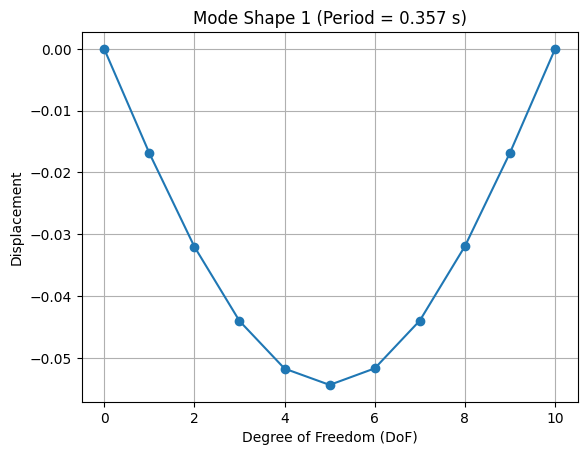

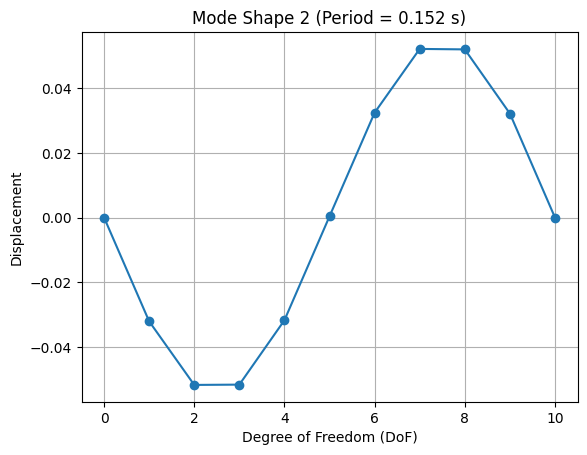

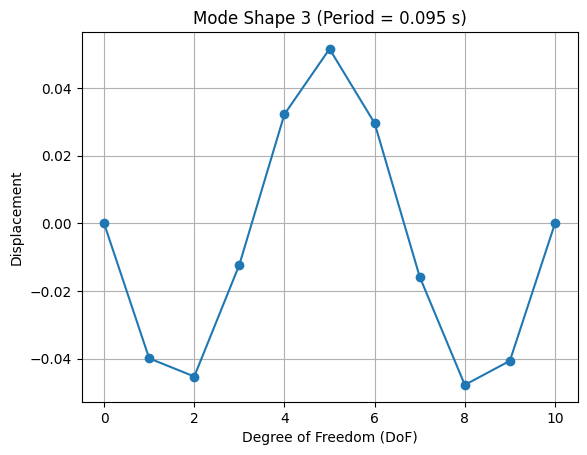

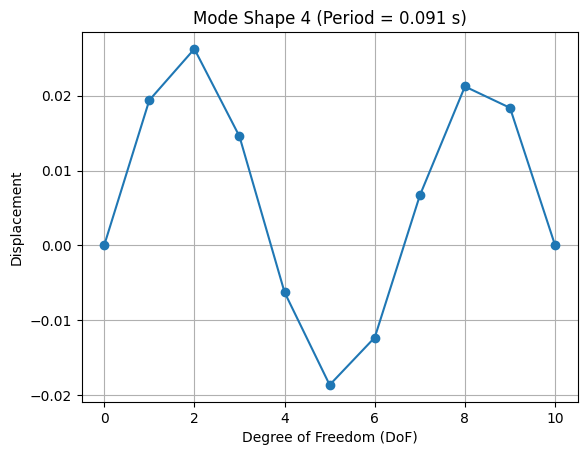

In [9]:
# Plot the relationship between the period and the mode shape
# Shows the expected displacement at each node for each mode
skip_dof = 3
dof_start = 1
for i, selected_mode in enumerate(index_modes):  # Plot up to 5 mode shapes
    plt.figure()
    try:
        plt.plot(phis_norm[dof_start:(n_bot_beams+1)*n_par_nod:skip_dof, selected_mode], 'o-')  # Assuming a 1D structure
    except:
        print("Error: normalized")
        plt.plot(phis_r[dof_start:(n_bot_beams+1)*n_par_nod:skip_dof, selected_mode], 'o-')  # Assuming a 1D structure
    plt.title(f"Mode Shape {i+1} (Period = {sorted_period[-i-1]:.3f} s)")
    plt.xlabel("Degree of Freedom (DoF)")
    plt.ylabel("Displacement")
    plt.grid()
    plt.show()


## Bridge Output for Mode Shapes

In [ ]:
# Compute the displacement of each node for each mode using Cython
X_new_sub, Y_new_sub, X_disp, Y_disp = compute_element_coordinates_cython(
    n_plots, n_ele_tot, n_rods, n_discritizations, span, spacing,
    X, Y, ele_nod, beta, h, pel, phis_plots, use_lagrangian
)

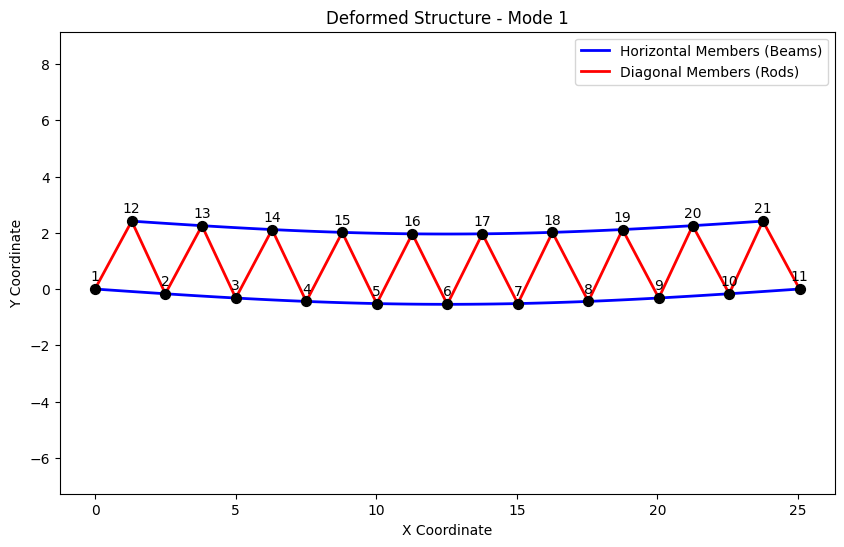

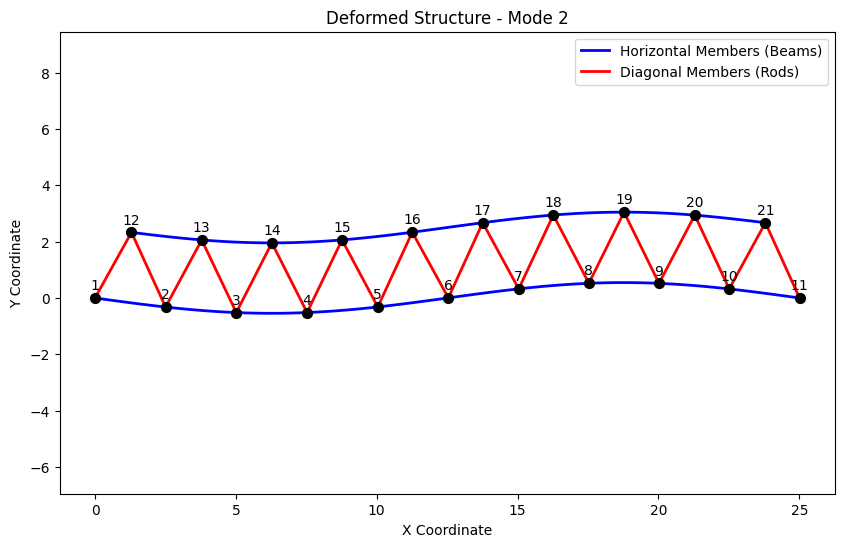

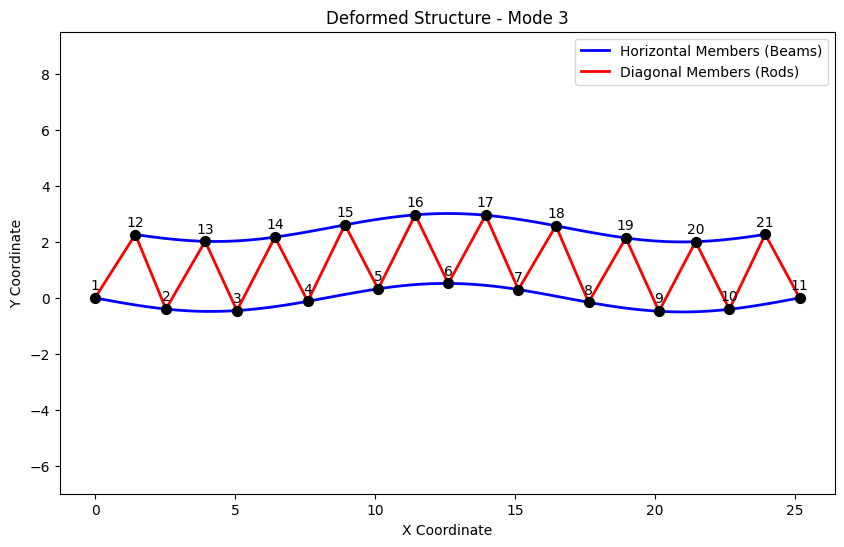

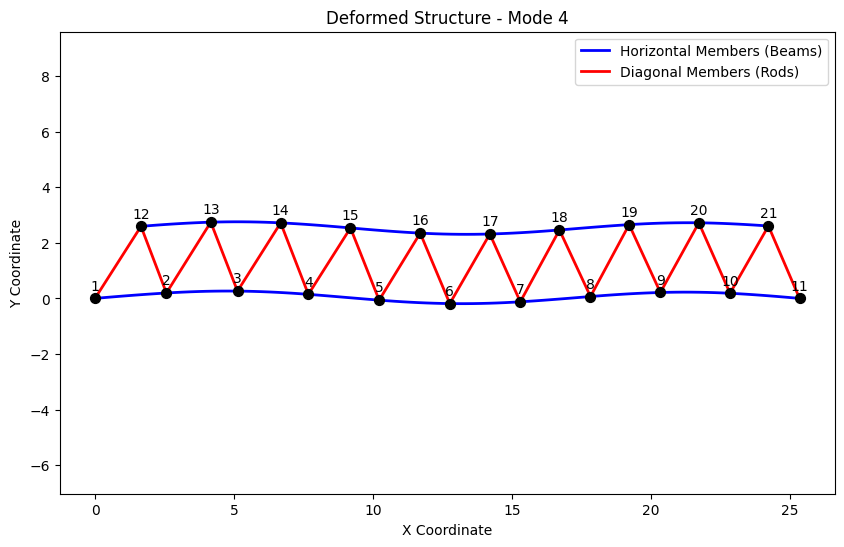

In [ ]:
# =============================================================================
# Define colors and labels (matching your labeled code)
# =============================================================================
horizontal_color = 'blue'
vertical_color   = 'green'
diagonal_color  = 'red'

horizontal_label = "Horizontal Members (Beams)"
vertical_label   = "Vertical Members (Columns)"
diagonal_label   = "Diagonal Members (Rods)"

# =============================================================================
# Arrays for storing discretized coordinates and net displacements
# =============================================================================
X_new_sub = np.zeros((n_plots, n_ele_tot, n_discritizations))
Y_new_sub = np.zeros((n_plots, n_ele_tot, n_discritizations))
X_disp    = np.zeros((n_plots, n_ele_tot))
Y_disp    = np.zeros((n_plots, n_ele_tot))

amplifier = int(span / spacing)

# =============================================================================
# Main loop: for each mode (j), plot the deformed structure
# =============================================================================
for j in range(n_plots):
    # Create a new figure for the current mode
    plt.figure(figsize=(10, 6))
    
    # Temporary arrays to accumulate node coordinates for averaging
    X_node_accum = np.zeros(n_nod_tot)
    Y_node_accum = np.zeros(n_nod_tot)
    node_count   = np.zeros(n_nod_tot)

    # -------------------------------------------------------------------------
    # Plot each element's deformed shape
    # -------------------------------------------------------------------------
    for e in range(n_ele_tot):
        # --- 1) Determine original orientation for color & label (like your labeled code)
        n1 = ele_nod[e, 0]
        n2 = ele_nod[e, 1]

        x1_orig, y1_orig = X[n1], Y[n1]
        x2_orig, y2_orig = X[n2], Y[n2]

        # Decide color/label based on original orientation and element index
        if y1_orig == y2_orig:  # Horizontal
            color_to_use = horizontal_color
            label_to_use = horizontal_label if e == 0 else ""
        elif x1_orig == x2_orig:  # Vertical
            color_to_use = vertical_color
            label_to_use = vertical_label if e == 18 else ""
        else:  # Diagonal
            color_to_use = diagonal_color
            label_to_use = diagonal_label if e == 28 else ""

        # --- 2) Choose the appropriate beam or rod function
        if e < n_ele_tot - n_rods:
            x_func = X_new_beam_func
            y_func = Y_new_beam_func
        else:
            x_func = X_new_rod_func
            y_func = Y_new_rod_func

        # --- 3) Prepare arguments for the shape function
        func_args = (
            X[n1],
            Y[n1],
            beta[e],
            h[e],
        ) + tuple(phis_plots[pel[e, i] - 1, j] * amplifier for i in range(n_par_ele))

        # --- 4) Discretize along [0,1] (Lagrangian) or [0,h[e]] (actual length)
        if use_lagrangian:
            plot_values = np.linspace(0, 1, 10)
        else:
            plot_values = np.linspace(0, h[e], 10)

        # --- 5) Calculate new (deformed) coordinates for this element
        X_new_sub[j, e] = x_func(plot_values, *func_args)
        Y_new_sub[j, e] = y_func(plot_values, *func_args)

        # Plot the element in its deformed shape
        plt.plot(
            X_new_sub[j, e],
            Y_new_sub[j, e],
            color=color_to_use,
            linewidth=2,
            label=label_to_use
        )

        # --- 6) Track net displacement (difference between end and start)
        X_disp[j, e] = X_new_sub[j, e][-1] - X_new_sub[j, e][0]
        Y_disp[j, e] = Y_new_sub[j, e][-1] - Y_new_sub[j, e][0]

        # --- 7) Accumulate node coordinates (start & end) for averaging
        # Start node's new position
        X_node_accum[n1] += X_new_sub[j, e][0]
        Y_node_accum[n1] += Y_new_sub[j, e][0]
        node_count[n1]   += 1

        # End node's new position
        X_node_accum[n2] += X_new_sub[j, e][-1]
        Y_node_accum[n2] += Y_new_sub[j, e][-1]
        node_count[n2]   += 1

    # -------------------------------------------------------------------------
    # Compute final node positions by averaging the contributions of all elements
    # -------------------------------------------------------------------------
    X_def_nodes = np.zeros(n_nod_tot)
    Y_def_nodes = np.zeros(n_nod_tot)

    for node_idx in range(n_nod_tot):
        if node_count[node_idx] > 0:
            X_def_nodes[node_idx] = X_node_accum[node_idx] / node_count[node_idx]
            Y_def_nodes[node_idx] = Y_node_accum[node_idx] / node_count[node_idx]
        else:
            # If somehow a node is unused (unlikely), fall back to original
            X_def_nodes[node_idx] = X[node_idx]
            Y_def_nodes[node_idx] = Y[node_idx]

    # -------------------------------------------------------------------------
    # Plot the deformed node positions and annotate
    # -------------------------------------------------------------------------
    plt.scatter(X_def_nodes, Y_def_nodes, color='black', s=50, zorder=3)
    for idx, (xd, yd) in enumerate(zip(X_def_nodes, Y_def_nodes)):
        plt.text(xd, yd + 0.3, str(idx + 1), fontsize=10, ha='center', color='black')

    # -------------------------------------------------------------------------
    # Final formatting for the current mode’s plot
    # -------------------------------------------------------------------------
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Deformed Structure - Mode {j+1}')
    plt.axis('equal')
    plt.legend(loc='upper right')
    plt.show()


In [44]:
# Get dimension of X_disp
X_disp.shape, phis_plots.shape, X_disp[0], X_disp[1]

((39, 4),
 (63, 4),
 array([2.49710688, 2.51107104, 2.39769564, 2.46241069]),
 array([2.4932581 , 2.51996989, 2.40834231, 2.47984783]))

## Dataset Creation
Must first create the geometry of the building

In [ ]:
import pandas as pd
from itertools import combinations, product
import random
# E damages 25 and 50 percent considered for up to 3 elements + mixed 4 and 5 elements 60k combinations
# Last data set 4 5 6 are fully generated (21 mins) and taken as a subset
# Use the lazy evaluation to generate the data for 4 5 6 elements and save it 
E_values = [E[0], E[0]*0.25, E[0]*0.5]
max_mixed = 7

In [23]:
def generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values):
    """
    Generate combinations with up to 'max_mixed' elements having mixed E values, lazily.
    
    Parameters:
    n_ele_tot (int): Total number of elements.
    max_mixed (int): Maximum number of elements to have mixed E values.
    E_values (numpy.ndarray or list): Array of possible E values.
    
    Yields:
    numpy.ndarray: A combination of E values.
    """
    E_values = np.array(E_values)

    if not E_values.ndim == 1:
        raise ValueError("E_values must be a 1D array of scalars.")
    
    for num_changes in range(max_mixed + 1):
        for indices in combinations(range(n_ele_tot), num_changes):
            base = np.full(n_ele_tot, E_values[0], dtype=E_values.dtype)
            for changed_values in product(E_values[1:], repeat=num_changes):
                new_comb = base.copy()
                for idx, value in zip(indices, changed_values):
                    new_comb[idx] = np.array(value, dtype=E_values.dtype)
                yield new_comb

comb_res2 = generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values)
comb_res2 = list(comb_res2)
len(comb_res2)

163856499

In [19]:
def generate_custom_combinations(n_ele_tot, max_mixed, E_values):
    """
    Generate combinations with up to 'max_mixed' elements having mixed E values.
    
    Parameters:
    n_ele_tot (int): Total number of elements.
    max_mixed (int): Maximum number of elements to have mixed E values.
    E_values (numpy.ndarray or list): Array of possible E values.
    
    Returns:
    list: List of combinations of E values.
    """
    # Convert E_values to a NumPy array if it's not already one
    E_values = np.array(E_values)

    if not E_values.ndim == 1:
        raise ValueError("E_values must be a 1D array of scalars.")
    
    result_combinations = []
    
    for num_changes in range(max_mixed + 1):
        for indices in combinations(range(n_ele_tot), num_changes):
            base = np.full(n_ele_tot, E_values[0], dtype=E_values.dtype)
            for changed_values in product(E_values[1:], repeat=num_changes):
                new_comb = base.copy()
                for idx, value in zip(indices, changed_values):
                    # Ensure value is of the same type as E_values elements
                    new_comb[idx] = np.array(value, dtype=E_values.dtype)
                result_combinations.append(new_comb)
    
    return result_combinations

comb_res = generate_custom_combinations(n_ele_tot, max_mixed, E_values)
comb_res = list(comb_res)

### Part 1: Generate elements 1 2 3 4

In [ ]:
# Save the first 130k combinations to csv
comb_res = generate_custom_combinations(n_ele_tot, max_mixed, E_values)
comb_res = list(comb_res)

df = pd.DataFrame(comb_res[:130000])

True

### Part 2: Generate elements 4 5 and take a subset of 60k for elements 4 5

In [ ]:
# Generate elements 4 5 
comb_res = generate_custom_combinations(n_ele_tot, max_mixed, E_values)
comb_res = list(comb_res)

df2 = pd.DataFrame(comb_res[150000:])

# Randomly sample 60k rows
df2 = df2.sample(n=60000, random_state=42)
pd.concat([df, df2], ignore_index=True)

df.to_csv('combos/bridge_combo12345.csv', index=False)

### Part 3: Generating extra subsets 4 5 6 7

In [32]:
def generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values, num_combinations):
    """
    Generate combinations with up to 'max_mixed' elements having mixed E values, lazily,
    selecting a random subset of 'num_combinations' from each level.
    
    Parameters:
    n_ele_tot (int): Total number of elements.
    max_mixed (int): Maximum number of elements to have mixed E values.
    E_values (numpy.ndarray or list): Array of possible E values.
    num_combinations (int): Number of combinations to randomly select from each level.
    
    Yields:
    numpy.ndarray: A combination of E values.
    """
    E_values = np.array(E_values)

    if not E_values.ndim == 1:
        raise ValueError("E_values must be a 1D array of scalars.")

    base = np.full(n_ele_tot, E_values[0], dtype=E_values.dtype)

    for num_changes in range(4, max_mixed + 1):
        # Calculate the number of possible index combinations and value permutations
        possible_index_combinations = list(combinations(range(n_ele_tot), num_changes))
        possible_value_permutations = list(product(E_values[1:], repeat=num_changes))

        num_possible_combinations = len(possible_index_combinations) * len(possible_value_permutations)

        if num_possible_combinations == 0:
            continue

        selected_indices = random.sample(range(num_possible_combinations), min(num_combinations, num_possible_combinations))

        for idx in selected_indices:
            index_combination = possible_index_combinations[idx // len(possible_value_permutations)]
            value_permutation = possible_value_permutations[idx % len(possible_value_permutations)]

            new_comb = base.copy()
            for idx, value in zip(index_combination, value_permutation):
                new_comb[idx] = value
            
            yield new_comb

comb_res = generate_custom_combinations_lazy(n_ele_tot, max_mixed, E_values, 30000)
comb_res = list(comb_res)

In [38]:
# Load the original dataframe
df = pd.read_csv('combos/bridge/bridge_combo12345.csv')

# Create DataFrame from comb_res
df3 = pd.DataFrame(comb_res, columns=df.columns)

# Merge df3 with df to find common rows, using an indicator to track the source of each row
merged_df = df3.merge(df.drop_duplicates(), indicator=True, how='left', on=df3.columns.tolist())

# Filter out rows that are found in both dataframes (those marked as 'both' by the merge indicator)
df3_cleaned = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# df3_cleaned now contains rows from df3 that are not found in df
df3_cleaned.to_csv('combos/bridge_combo4567.csv', index=False)

In [39]:
df2_cleaned.shape

(118711, 39)